### Use scipy.optimize

In [1]:
from scipy.optimize import curve_fit
import numpy as np

In [2]:
vol = np.array([ 49.14835132,  48.95387966,  48.8291772,   57.47423436,  53.40459584,  39.85244873,  39.84663685,  49.2232604,
       48.882031, 38.79104303])
cur = np.array([ 1.99044514,  0.9919535,   0.69317581,  2.18901812,  0.99226583,  0.99202458, 0.49062936,  0.49075445,  1.99087761,
       1.99084474])
rate = np.array([ 0.89986609, 0.42571558,  0.2892334,  1.52508731,  0.55962977,  0.21261142,  0.10024236,  0.20604203,  0.88737798,
        0.38697821])
rate_err = np.array([ 0.01588928,  0.00614813,  0.00418711,  0.02155168,  0.01026643,  0.00312938, 0.00153864,  0.00294942,
            0.01257681,  0.00570924])

In [3]:
def f_rate(vi, prefactor, v_power, i_power):
    v, i = vi
    return prefactor*(v**v_power)*i**i_power

p0 = [1E-6, 3.5, 1.]
popt, pcov = curve_fit(f_rate, (vol, cur), rate, p0=p0, sigma=rate_err)

In [4]:
print('Result for Eriks Windows python version: popt = array([  1.08470160e-06,   3.30763171e+00,   1.02735433e+00])')
print('Result for Eriks Windows python version: popt = array([  1.08470160e-06,   3.30763171e+00,   1.02735433e+00])')

Result for Eriks Windows python version: popt = array([  1.08470160e-06,   3.30763171e+00,   1.02735433e+00])
Result for Eriks Windows python version: popt = array([  1.08470160e-06,   3.30763171e+00,   1.02735433e+00])


### Try unreasonable start values

In [5]:
# Check for dependence on initial values
# Take random start values in range 0-10 for I and U exponent, in range 0 - 1e-5 for prefactor
for i in range(10):
    p0 = [np.random.rand()*10e-6, np.random.rand()*10, np.random.rand()*10]
    popt, pcov = curve_fit(f_rate, (vol, cur), rate, p0=p0, sigma=rate_err)
    print(popt, p0)

[  1.08470128e-06   3.30763179e+00   1.02735433e+00] [9.837130529641048e-06, 1.0567106454160702, 0.8938885573504451]
[  1.08470138e-06   3.30763177e+00   1.02735433e+00] [1.3334648389036865e-07, 5.03113594900288, 5.520354368670098]
[  1.08470146e-06   3.30763175e+00   1.02735433e+00] [9.363003079396648e-06, 5.633492164792334, 8.018353750289196]
[  1.08470140e-06   3.30763176e+00   1.02735433e+00] [1.3723699806951563e-06, 2.624842103512192, 1.123543424174912]
[  1.08470129e-06   3.30763179e+00   1.02735433e+00] [7.394255860861325e-06, 1.2921558900147478, 4.254120223186519]
[  1.08470129e-06   3.30763179e+00   1.02735433e+00] [9.192466462952326e-06, 1.7291472849471845, 4.057352891528611]
[  1.08470127e-06   3.30763179e+00   1.02735433e+00] [5.911553723094813e-06, 1.8271854143295607, 6.654895685211928]
[  1.08470123e-06   3.30763180e+00   1.02735433e+00] [4.043961364202612e-06, 8.938060400973152, 8.17218481099107]
[  1.08470113e-06   3.30763183e+00   1.02735433e+00] [7.68091228594578e-06,

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


### Use a different minimizer

In [6]:
from iminuit import Minuit, describe

In [7]:
def f_rate_minuit(v, i, prefactor, v_power, i_power):
    return prefactor*(v**v_power)*i**i_power

In [8]:
class Chi2:
    def __init__(self,f,vol,cur,rate, rate_err):
        self.f = f
        self.vol = vol
        self.cur = cur
        self.rate = rate
        self.rate_err = rate_err
        f_sig = describe(f)
        
        #this is how you fake function 
        #signature dynamically
#         self.func_code = make_func_code( f_sig[1:] )#docking off independent variable
#         self.func_defaults = None #this keeps np.vectorize happy

    def __call__(self,*arg):
        #notice that it accept variable length
        #positional arguments
        chi2 = sum( ( rate - self.f(vol, cur, *arg) )**2 / rate_err**2  
                   for rate, vol, cur, rate_err in zip(self.rate,self.vol,self.cur, self.rate_err))
        return chi2    

In [9]:
chi2 = Chi2(f_rate_minuit, vol, cur, rate, rate_err)

In [10]:
myvals = {'prefactor': 1e-6, 'v_power': 4.0, 'i_power': 1.5}
forced_parameters=['prefactor','v_power','i_power']
m=Minuit(chi2, forced_parameters = forced_parameters, **myvals) # m=Minuit(chi2) # 

print(m.values)
m.migrad()
print('Values found: ', m.values)
print('Errors found: ', m.errors)

{'prefactor': 1e-06, 'i_power': 1.5, 'v_power': 4.0}


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: InitialParamWarning: errordef is not given. Default to 1.
  app.launch_new_instance()
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter prefactor is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter v_power is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: InitialParamWarning: Parameter i_power is floating but does not have initial step size. Assume 1.
  app.launch_new_instance()


FCN = 32.86873310384783 
 TOTAL NCALL = 421 
 NCALLS = 421 
 
 
 EDM = 2.991595619610985e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,prefactor,1.08398e-06,1.61952e-07,0,0,,,
2,v_power,3.3078,0.0388421,0,0,,,
3,i_power,1.02737,0.0086296,0,0,,,


Values found:  {'prefactor': 1.0839774916972308e-06, 'i_power': 1.0273675755168616, 'v_power': 3.307804223124495}
Errors found:  {'prefactor': 1.6195234595439715e-07, 'i_power': 0.008629603987238735, 'v_power': 0.038842071148113236}


### Don't give the errors

In [11]:
p0 = [1E-6, 3.5, 1.]
popt, pcov = curve_fit(f_rate, (vol, cur), rate, p0=p0, sigma=rate_err)

In [12]:
popt

array([  1.08470160e-06,   3.30763171e+00,   1.02735433e+00])

### Convert to actual numbers in a quick-and-dirty way

In [13]:
d_eff = 150.0 + 4.06 + 7.2 + 13.8/2 # Effective distance: distance outside NG-Cd shield + effective center + distance Cd - reference plane + radius NG
s_eff = 4*np.pi*d_eff**2 # Effective surface area of sphere
phi = np.array(rate)/3.515 # Flux at 0 degrees and this distance

In [14]:
def gauss(x, A, sigma):
    return A*np.exp(-x**2/(2*sigma**2))
popt_g = np.array([  0.98970953,  50.42659426])
# average over all angles
rate_v_angle_gauss = [gauss(angle, 1., popt_g[1]) for angle in np.linspace(-90,90,200)]
angular_corr = np.average(rate_v_angle_gauss)

In [15]:
conversion_factor = s_eff * angular_corr * 1/3.515

In [16]:
n_per_sec = phi * s_eff * angular_corr
n_per_sec_err = np.array(rate_err)/np.array(rate) * n_per_sec

In [17]:
conversion_factor * np.array(rate)

array([ 58932.88041235,  27880.42092553,  18942.10434517,  99879.06984985,
        36650.55798536,  13924.07551346,   6564.94458429,  13493.84141579,
        58115.02506544,  25343.48257541])

In [18]:
%run function_definitions.ipynb
import pylab

In [19]:
v_min = 35
v_max = 60
i_min = 0.4
i_max = 2.5
rate_min = 5e3
rate_max = 1e5
n_gridpoints = 101
log_color = True
x_label = 'Voltage (kV)'
y_label = 'Current (mA)'
point_size = 200
#c_ticks = None #  None is automatic
#c_ticks = [0.1, 0.17, 0.3, 0.5, 1, 2]
c_ticks = [5e3, 1e4, 3e4, 1e5]
c_tick_labels = ['5e3', '1e4', '3e4', '1e5']

In [20]:
# Initialize background colors given by fit
xx, yy = pylab.meshgrid(
    pylab.linspace(v_min,v_max, n_gridpoints),
    pylab.linspace(i_min,i_max,n_gridpoints))

zz = pylab.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i,j] = conversion_factor * f_rate((xx[i,j], yy[i,j]), *popt)

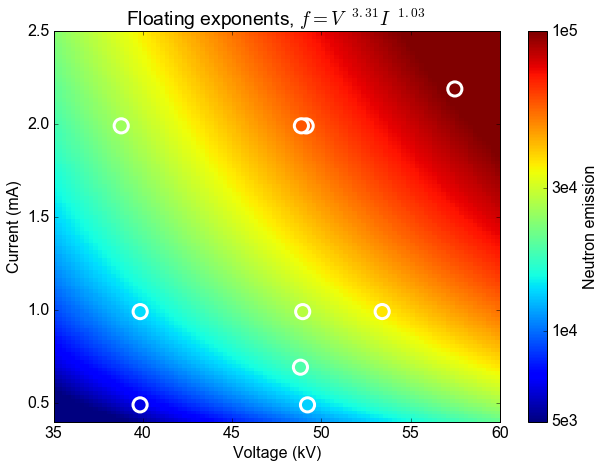

In [22]:
#plt.set_c
fig = plt.figure(figsize=(10,7))
ax1 = fig.gca()
# Plot fit 
if log_color:
    pylab.pcolor(xx,yy,zz, vmin=rate_min, vmax=rate_max, norm=LogNorm())
else:
    pylab.pcolor(xx,yy,zz, vmin=rate_min, vmax=rate_max)

if log_color:
    plt.scatter(vol, cur, c = conversion_factor * rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, norm=LogNorm(), linewidth=3)
else:
    plt.scatter(vol, cur, c = conversion_factor * rate, edgecolors='white', s=point_size, vmin=rate_min, vmax=rate_max, linewidth=3)

cbar = plt.colorbar(label='Neutron emission', ticks = c_ticks)
cbar.ax.set_yticklabels(c_tick_labels)   
plt.xlim(v_min, v_max)
plt.ylim(i_min, i_max)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Floating exponents, $f = V^{\ \ %.2f}  I^{\ \ %.2f}$ " % (popt[1], popt[2]))
# plt.savefig('PTB_rate_UI.png', bbox_inches = 'tight')
# plt.savefig('PTB_rate_UI.pdf', bbox_inches = 'tight')

array([ 58932.88041235,  27880.42092553,  18942.10434517,  99879.06984985,
        36650.55798536,  13924.07551346,   6564.94458429,  13493.84141579,
        58115.02506544,  25343.48257541])

In [24]:
vol

array([ 49.14835132,  48.95387966,  48.8291772 ,  57.47423436,
        53.40459584,  39.85244873,  39.84663685,  49.2232604 ,
        48.882031  ,  38.79104303])

In [25]:
cur

array([ 1.99044514,  0.9919535 ,  0.69317581,  2.18901812,  0.99226583,
        0.99202458,  0.49062936,  0.49075445,  1.99087761,  1.99084474])

In [36]:
rate_v_angle_gauss = [gauss(angle, 1., popt_g[1]) for angle in np.linspace(-90,90,200)]
rate_v_angle_gauss_cos = [gauss(angle, 1., popt_g[1]) * np.cos(angle/180*np.pi) for angle in np.linspace(-90,90,200)]
angular_corr = np.average(rate_v_angle_gauss)

angular_corr

0.64781328461944265

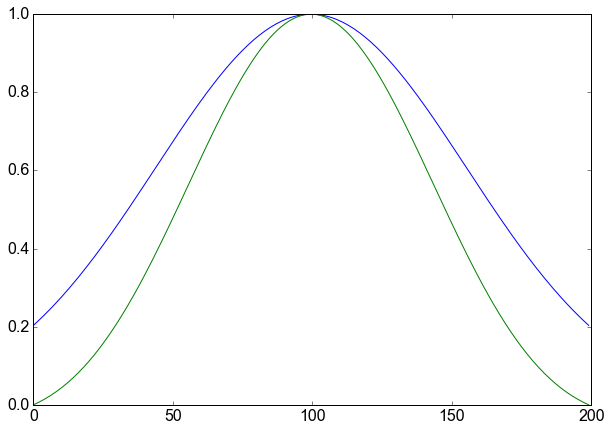

In [37]:
plt.plot(rate_v_angle_gauss)
plt.plot(rate_v_angle_gauss_cos)